## Local Import

* working localy trim the data to ensure you can work with it locally <br\>*(my computer does not have sufficient local memory to join all tables so I use appropriate attributes)*

attempted stratagy (merge pd_df until memory bound then print to file)

In [1]:
import json, csv, os
import pandas as pd


def JSON_to_dataFrame(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() ] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df


In [134]:
root_path = "/Users/2015mbp16gb256gb/Documents/school/Fall_2019/4502-Data_Mining/Group_Project/Group1/yelp_dataset/"
rbu_path = root_path + "rbu_merge.json"
filtered_merge_path = root_path + "filtered_merge.json"

## Reviewing Business File

In [ ]:
import sys
try: 
    !{sys.executable} -m pip install plotly --upgrade
    !{sys.executable} -m pip install geopandas==0.3.0
    !{sys.executable} -m pip install pyshp==1.2.10
    !{sys.executable} -m pip install shapely==1.6.3
    !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.2"
    !{sys.executable} -m pip install chart_studio
    !{sys.executable} -m pip install plotly-geo
except: 
    print("already installed")

In [34]:

%matplotlib inline
import numpy as np
import matplotlib as plt

# clustering imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# plotly imports 
import plotly
from plotly import __version__
print('running plotly = {}'.format(__version__))
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objects as go

from sklearn.decomposition import PCA 

running plotly = 4.2.1


In [4]:
init_notebook_mode(connected=True)

In [121]:
%%time

business_df = JSON_to_dataFrame(root_path + "business.json")
business_df['text'] = business_df['state'] + ', ' + business_df['city']

CPU times: user 5.32 s, sys: 2.72 s, total: 8.04 s
Wall time: 9.31 s


### Kmeans Attempt

* Kmeans can be sensative to outliers
* this can mess up our centroid 
* we are not to consern since we are only evaluating sections to the us
* 

In [6]:
# transform the data 

coordinates_df = business_df[['longitude','latitude']].copy()

pca = PCA(n_components=2)
coordinates = pca.fit_transform(coordinates_df)

In [7]:
#Train model
kmeans = KMeans(n_clusters=5).fit(coordinates)

In [8]:
business_df['lables'] = pd.DataFrame(kmeans.labels_)

In [10]:
# plot cluster informaiton
'''
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = business_df['longitude'],
        lat = business_df['latitude'],
        text = business_df['text'],
        mode = 'markers',
        marker_color = business_df['lables'],
        ))

fig.update_layout(
        title = 'US Cluster<br>(hover for spicific informaiton)',
        geo_scope='usa',
    )
fig.show()
'''

"\nimport plotly.graph_objects as go\n\nfig = go.Figure(data=go.Scattergeo(\n        lon = business_df['longitude'],\n        lat = business_df['latitude'],\n        text = business_df['text'],\n        mode = 'markers',\n        marker_color = business_df['lables'],\n        ))\n\nfig.update_layout(\n        title = 'US Cluster<br>(hover for spicific informaiton)',\n        geo_scope='usa',\n    )\nfig.show()\n"

![img](map.png)

#### AZ has the highest posotive stars than all other states followed by NV which is in the same group. So lets take a closter look at AZ. 

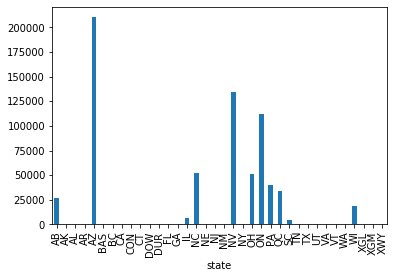

In [124]:
star_business_by_state = business_df.groupby('state').stars.sum().plot(kind='bar')


*********
### Merging Files
* paired the information down by combining the review business and user json files in to one merged csv file for processing (rbu_merged.csv) (deleted the other files and will be using this one to save space on my computer, if we need additional columns we will have to run this over adding the column)

In [107]:
%%time

review_df = JSON_to_dataFrame(root_path + "review.json")
business_df = JSON_to_dataFrame(root_path + "business.json")
user_df = JSON_to_dataFrame(root_path + "user.json")
# tip_df = JSON_to_dataFrame(root_path + "tip.json")                     /not used
# checkin_df = JSON_to_dataFrame(root_path + "checkin.json")             /not used

CPU times: user 2min 26s, sys: 2min 5s, total: 4min 32s
Wall time: 5min 38s


In [108]:
# utility function to make a dict of columns with table name added
# used for the renaming of column names
def make_columns(lst, base):
    ret = {}
    for i in lst:
        ret[i] = base + '_' + i
    return ret

In [109]:
# return dataframe with column names updated to "table + _column_name"
def process_df(a_df, table): 

    col_list = [i for i in a_df]
    new_dict = make_columns(col_list, table)
    return a_df.rename(columns=new_dict)

In [110]:
%%time

# review col = ['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

# ***Update review_df*** 
review_drop = ['cool','funny']
review_df = review_df.drop(review_drop, axis=1)

review_df = process_df(review_df, 'review')

CPU times: user 10.2 s, sys: 29 s, total: 39.2 s
Wall time: 48.5 s


In [111]:
%%time

# business col = 
# ['address','attributes','business_id','categories','city','hours','is_open',              
# 'latitude','longitude','name','postal_code','review_count','stars','state']                              

# ***Update business_df***
business_drop = ['address', 'attributes', 'categories','city', 'postal_code']
business_df = business_df.drop(business_drop, axis=1)

business_df = process_df(business_df, 'business')

CPU times: user 1.14 s, sys: 2.68 s, total: 3.82 s
Wall time: 5.67 s


In [112]:
%%time

rb_merge = pd.merge(review_df, business_df, left_on='review_business_id', right_on='business_business_id', how='inner')

CPU times: user 21.1 s, sys: 888 ms, total: 22 s
Wall time: 20.9 s


In [113]:
%%time

# user col = 
# ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list',           
# 'compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer', 
# 'cool','elite','fans','friends','funny','name','review_count','useful','user_id','yelping_since']   

# ***Update _user_df***
user_drop = ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list','compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer','cool', 'elite', 'fans','friends','funny']
user_df = user_df.drop(user_drop, axis=1)

user_df = process_df(user_df, 'user')

CPU times: user 5.62 s, sys: 13.2 s, total: 18.8 s
Wall time: 24.4 s


In [114]:
%%time

rbu_merge = pd.merge(rb_merge, user_df, left_on='review_user_id', right_on='user_user_id', how='inner')

CPU times: user 24.8 s, sys: 13 s, total: 37.8 s
Wall time: 41.9 s


In [115]:
%%time

rbu_drop = ['review_business_id','review_user_id', 'business_hours']
rbu_merge = rbu_merge.drop(rbu_drop, axis=1)


CPU times: user 27.4 s, sys: 13 s, total: 40.4 s
Wall time: 39.4 s


In [116]:
for col in rbu_merge: 
    print(col)

review_review_id
review_stars
review_useful
review_text
review_date
business_business_id
business_name
business_state
business_latitude
business_longitude
business_stars
business_review_count
business_is_open
user_user_id
user_name
user_review_count
user_yelping_since
user_useful


Drop all states that are not NV or AZ

In [130]:
rbu_merge.shape

(6685900, 18)

In [128]:
filtered_merge = rbu_merge[rbu_merge['business_state'] == 'AZ'].copy()

In [132]:
filtered_merge.shape

(2082951, 18)

*********
### Writing Merged DataFrame Back To Json

In [133]:
def df_to_json(df, path):
    new_dict = {}
    num_col = len([i for i in df])

    with open(r'{}'.format(path), 'w') as writer: 

        for row in df.itertuples():
            
            for idx, col in enumerate(df): 
                if type(row[idx+1]) == int: 
                    new_dict[col] = int(row[idx+1])
                if type(row[idx+1]) == float: 
                    new_dict[col] = float(row[idx+1])
                else: 
                    new_dict[col] = str(row[idx+1])
                
            writer.write(json.dumps(new_dict) + '\n')
            new_dict = {}         



In [135]:
%%time

df_to_json(filtered_merge, filtered_merge_path)

CPU times: user 1min 29s, sys: 4.39 s, total: 1min 34s
Wall time: 1min 36s


********

## Unit Test

In [ ]:
test_in_path = root_path + 'test.json' 

test_df = JSON_to_dataFrame(test_in_path)

In [ ]:
%%time

test_out_path = root_path + 'test_out.json' 

parse_DataFrame1(test_df, test_out_path)

In [ ]:
test2_df = JSON_to_dataFrame(test_out_path)

In [ ]:
def test_DataFrame_to_Json(a_df_1, a_df_2): 
    
    df_list_1 = []
    df_list_2 = []
    catch_list = []
    
    for row in a_df_1.itertuples():
            
            for idx, col in enumerate(a_df_1):
                df_list_1.append((type(row[idx]), col))
                
    for row_2 in a_df_2.itertuples():
            
            for idx_2, col_2 in enumerate(a_df_2):
                df_list_2.append((type(row[idx_2]), col_2))
                
    for x,y in zip(df_list_1, df_list_2): 
        if x != y: 
            catch_list.append((x, y))
            
    for i in catch_list: 
        print(i)             # dataFrams have different types

In [ ]:
def JSON_to_dataFrame_2(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() [-500000:]] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

In [ ]:
df1 = JSON_to_dataFrame_2(rbu_path)

In [ ]:
# smaller scale test on business set
test_DataFrame_to_Json(rbu_merge, rbu_complete_df)

In [ ]:
# test on full merged data set
test_DataFrame_to_Json(rbu_merge, rbu_complete_df)

## Functions to check file given error message

In [ ]:
check_input_output(test_in_path, test_out_path, log_path)

In [ ]:
def check_input_output(a_test_in_path, a_test_out_path, a_log_path):
    line_count = 0
    char_count = 0
    save1 = ""
    save2 = []
    cnt1 = 0
    cnt2 = 0
    
    with open(a_test_in_path, 'r') as read1, open(a_test_out_path, 'r') as read2: 
        for x, y in zip(read1, read2):
            x = x.strip()
            y = y.strip()
            
            in_line = x.split()
            out_line = y.split()
            for word1, word2 in zip(in_line, out_line):
                
                save2.append(word1)
                
                if cnt1 > 5:
                    save2.pop(0)
                cnt1 = cnt1 + 1

            
                word_list = list(word2)
                
                for char in word_list: 
                    save1 = save1 + char
                    if cnt2 > 70: 
                        save1 = save1[1:]
                    
                    if char_count == 139: 
                        print(save1)
                        print(" ".join(save2))
                        
                    char_count = char_count + 1
                    cnt2 += 1
                
            line_count = line_count + 1


            

In [ ]:
with open(test_out_path, 'r') as reader: 
    for i in reader: 
        print(i)

****
## GCP Import
* login cradentaials provided to work with yelp_db database

In [ ]:
import sys
!{sys.executable} -m pip install PyMySQL

### MySql Server is nessisary to connect to GCP
* https://dev.mysql.com/downloads/mysql/

In [ ]:
import pymysql, os, sys, json
from IPython.display import clear_output
import multiprocessing as mp

In [ ]:
# read json file
file = "Group1/review.json"

json_data = open(file, encoding="utf8")
json_obj = [json.loads(x) for x in json_data.readlines()]


In [ ]:
num = len(json_obj)
print(num)

In [ ]:
# validate data before inserting
# TODO: check if string is the right type 
# TODO: check for duplicate data
# TODO: check for bad formats (date)

def validate_string(val): 
    if val != None: 
            if type(val) is int: 
                return str(val).encode('utf-8')
            else: 
                return val
            

### Processing takes to long so I used multiprocessing to speed up importing to host
* executing insert into gcp is atomic

this will take over 4 days to import one table!

In [ ]:
def insert_review(cursor, item, lock): 
          
    review_id = validate_string(item['review_id'])
    business_id = validate_string(item['business_id'])
    cool = validate_string(item['cool'])
    date = validate_string(item['date'])
    funny = validate_string(item['funny'])
    stars = validate_string(item['stars'])
    text = validate_string(item['text'])
    useful = validate_string(item['useful'])
    user_id = validate_string(item['user_id'])
    
    query = "INSERT INTO review(review_id,business_id,cool,date,funny,stars,text,useful,user_id) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)"
    args = (review_id, business_id, cool, date, funny, stars, text, useful, user_id)
    lock.acquire()
    cursor.execute(query, args)
    lock.release()
    
    clear_output()
    cnt.value = cnt.value + 1
    print(cnt.value)
    
    

In [ ]:
# connect to GCP MySql db insert data into review table
con = pymysql.connect(host = '104.198.65.208', user='root', password = 'hackme', db = 'yelp_db')

cnt = mp.Value('i', 0)
lock = mp.Lock()
pool = mp.Pool()


try: 
    with con.cursor() as cursor:
        
        # parse json data to SQL
        # use map to update each row in GCP
        result = pool.map([ insert_review(cursor, item, lock) for item in json_obj ])
            
finally:
    con.commit()
    con.close()
    